# OmniCell 模型推理获取细胞嵌入  
## OmniCell Model Inference for Cell Embeddings  

欢迎使用 **OmniCell**  
Welcome to **OmniCell**

本文档说明如何使用 OmniCell 模型对单细胞数据进行推理，并获得细胞嵌入表示。  
This document explains how to use the OmniCell model to perform inference on single-cell data and obtain cell embeddings.

---

## 一、输入数据说明  
### Input Data Description  

模型推理的输入是一个 `AnnData` 对象 `adata`。  
The input for model inference is an `AnnData` object named `adata`.

在推理前请确保满足以下条件：  
Before inference, please ensure the following requirements are met:

- `adata` 是标准的 `AnnData` 对象  
  `adata` is a standard `AnnData` object  

- `adata.var_names` **必须为 Ensembl Gene ID**  
  `adata.var_names` **must be Ensembl Gene IDs**  

- `adata` 中包含用于模型推理的基因表达矩阵  
  `adata` contains the gene expression matrix used for inference  

---

## 二、模型实例化  
### Model Initialization  

下面展示 OmniCell 中 `CellFormer` 的模型实例化方式：  
Below is the model initialization example for `CellFormer` in OmniCell:

```python
cellformer = CellFormer(
    checkpoint_dir=checkpoint_dir,
    dtype=torch.bfloat16,
    batch_size=10,
    vocab_path=vocab_path,
    n_genes=2000,
    mode="sc",
    threshold=0.9,
    selected_genes=highly_variable_genes
)
```
## 三、参数说明  
### Parameter Description  

- `checkpoint_dir`：模型权重文件所在目录  
  `checkpoint_dir`: Directory containing the model checkpoint files  

- `dtype`：模型计算精度，推荐使用 `torch.bfloat16`  
  `dtype`: Numerical precision for model computation, `torch.bfloat16` is recommended  

- `batch_size`：模型推理时的批大小  
  `batch_size`: Batch size used during inference  

- `vocab_path`：基因词表文件路径  
  `vocab_path`: Path to the gene vocabulary file  

- `n_genes`：模型使用的基因数量  
  `n_genes`: Number of genes used by the model  

- `mode`：数据模式，单细胞任务使用 `"sc"`  
  `mode`: Data mode, use `"sc"` for single-cell tasks  

- `threshold`：基因筛选阈值  
  `threshold`: Threshold for gene filtering  

- `selected_genes`：用于模型推理的基因集合  
  `selected_genes`: Gene set used for model inference  

---

## 四、关于 selected_genes  
### About selected_genes  

`selected_genes` 可以根据具体研究需求灵活选择。  
`selected_genes` can be flexibly selected based on specific research needs.

通常推荐选择高变基因作为模型输入。  
In most cases, it is recommended to use highly variable genes as model input.

```python
# 示例：使用高变基因
# Example: using highly variable genes
highly_variable_genes = adata.var_names[adata.var["highly_variable"]]
```
## 五、模型推理  
### Model Inference  

使用 OmniCell 模型对输入的 `adata` 进行推理，以获得每个细胞的嵌入表示。  
Use the OmniCell model to perform inference on the input `adata` to obtain cell-level embeddings.

模型推理通过 `infer` 方法完成。  
Model inference is performed using the `infer` method.

```python
cell_embedding, _ = cellformer.infer(adata)
```


In [1]:
import scanpy as sc
import os
notebook_dir = os.getcwd()
parent_parent_dir = os.path.dirname(notebook_dir)
import sys
sys.path.insert(0, parent_parent_dir)
from OmniCell.utils.symbol_ensemble import convert_var_names_to_ensembl, create_gene_mapping_dicts
from OmniCell.loader.CellEmbedding import CellFormer
from task.Cluster.cell_embedding_task import evaluate_cell_embedding
import torch
import numpy as np
import pandas as pd
checkpoint_dir = parent_parent_dir +  "/OmniCell/checkpoint"
vocab_path = parent_parent_dir + "/OmniCell/vocab/Vocabulary.json"
save_dir_path = parent_parent_dir + "/results/Cluster"

In [2]:
h5ad_file = parent_parent_dir + "/data/Cluster/blood.h5ad"

In [3]:
adata = sc.read_h5ad(h5ad_file)
adata = adata[adata.obs["cell_type"] != "unknown", :].copy()

In [4]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000, 
    flavor='seurat', 
)


highly_variable_genes = adata.var_names[adata.var['highly_variable']].tolist()

In [5]:
cellformer = CellFormer(checkpoint_dir=checkpoint_dir,
           dtype=torch.bfloat16,
           batch_size=10,
           vocab_path=vocab_path,
           n_genes=2000,
           mode="sc",
           threshold=0.9,
           selected_genes=highly_variable_genes)

Loaded parameter: embedder.gene_embedding.weight
Loaded parameter: embedder.value_embedding.shared_experts.0.weight
Loaded parameter: embedder.value_embedding.shared_experts.1.weight
Loaded parameter: embedder.value_embedding.shared_experts.2.weight
Loaded parameter: embedder.value_embedding.shared_experts.3.weight
Loaded parameter: embedder.value_embedding.shared_experts.4.weight
Loaded parameter: embedder.value_embedding.routing_experts.0.weight
Loaded parameter: embedder.value_embedding.routing_experts.1.weight
Loaded parameter: embedder.value_embedding.routing_experts.2.weight
Loaded parameter: embedder.value_embedding.routing_experts.3.weight
Loaded parameter: embedder.value_embedding.routing_experts.4.weight
Loaded parameter: embedder.value_embedding.routing_experts.5.weight
Loaded parameter: embedder.value_embedding.routing_experts.6.weight
Loaded parameter: embedder.value_embedding.routing_experts.7.weight
Loaded parameter: embedder.value_embedding.routing_experts.8.weight
Load

In [6]:
cell_embedding, _  = cellformer.infer(adata)

Number of matched genes: 21231/21231


Processing cells: 100%|██████████| 7557/7557 [00:00<00:00, 18693.37it/s]


📊 Single Cell dataset: 7557 cells


Inferencing: 100%|██████████| 756/756 [00:28<00:00, 26.48batch/s]

✅ Inference complete, total embedding dimension: (7557, 316), expression value dimension: (7557, 2000)


In [8]:
cell_embedding.shape

(7557, 316)

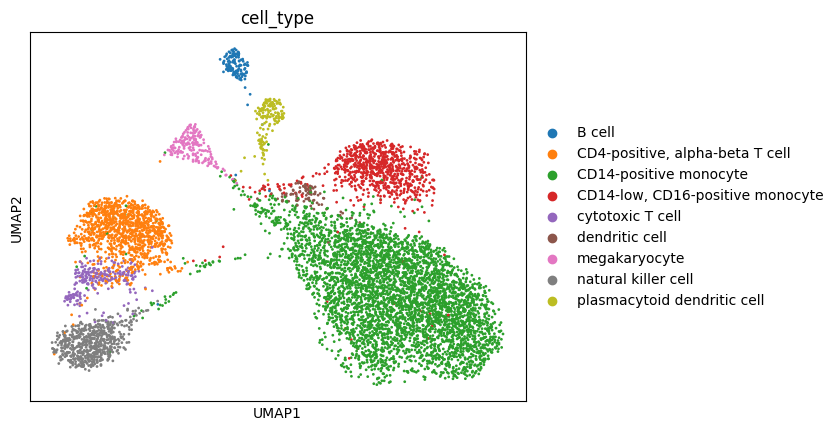

In [9]:
adata.obsm['X_OmniCell'] = cell_embedding
sc.pp.neighbors(adata, use_rep='X_OmniCell')
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type')